# Imaging conditions in JUDI

Overview of JUDI imaging conditions for inversion

In [1]:
using JUDI, LinearAlgebra, PyPlot

In [2]:
# Set up model structure
n = (601, 151)   # (x,y,z) or (x,z)
d = (10f0, 10f0)
o = (0., 0.)

# Velocity [km/s]
v = ones(Float32,n) .+ 0.5f0
v0 = ones(Float32,n) .+ 0.51f0
v[:, 101:end] .= 2f0
v0[:, 101:end] .= 2f0

# Slowness squared [s^2/km^2]
m = (1f0 ./ v).^2
m0 = (1f0 ./ v0).^2

# Setup model structure
nsrc = 1	# number of sources
model = Model(n, d, o, m)
model0 = Model(n, d, o, m0)

Model (n=(601, 151), d=(10.0f0, 10.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]

In [11]:
# Set up receiver geometry
xrec = 4500
yrec = 0f0 # WE have to set the y coordiante to zero (or any number) for 2D modeling
zrec = d[1]

# receiver sampling and recording time
timeD = 2500f0   # receiver recording time [ms]
dtD = 4f0    # receiver sampling interval [ms]

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dtD, t=timeD, nsrc=nsrc)

xsrc = 1500
ysrc = 0f0
zsrc = d[1]

# Set up source structure
srcGeometry = Geometry(xsrc, ysrc, zsrc; dt=dtD, t=timeD)

GeometryIC{Float32} wiht 1 sources


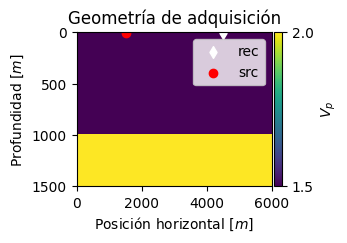

PyObject <matplotlib.legend.Legend object at 0x7f60912883d0>

In [12]:
fig=figure(figsize=(3,2));
im = imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0], aspect="auto")
scatter(xrec, zrec, label="rec", color="w", marker="d")
scatter(xsrc, zsrc, label="src", color="red")
cb = colorbar(im, ticks=unique(v), pad=0.01)
cb[:set_label](label = L"$V_p$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Geometría de adquisición")
legend();
# display(fig)

In [13]:
# setup wavelet
f0 = 0.03f0     # kHz
wavelet = ricker_wavelet(timeD, dtD, f0)
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 1 sources


In [14]:
F = judiModeling(model, srcGeometry, recGeometry)
F0 = judiModeling(model0, srcGeometry, recGeometry)
dobs = F*q

Operator `forward` ran in 0.08 s


judiVector{Float32, Matrix{Float32}} with 1 sources


We compute now the FWI gradient with three different imaging conditions:

- "as" adjoint state imaging condition. This is the conventional cross-correlation adjoint state gradient.
- "isic" that computes the inverse scattering imaging condition designed to provide reflections for LSRTM (high frequency content)
- "FWI" that computes the complement of "isic" and brings up the low frequency content for velocity inversion

These can be specified in the Option structure via IC="as/isic/fwi. (i.e isic + fwi = as)

In [15]:
fas, g_as = fwi_objective(model0, q, 0*dobs; options=Options(IC="as", space_order=12))
fisic, g_isic = fwi_objective(model0, q, 0*dobs; options=Options(IC="isic", space_order=12))
ffwi, g_fwi = fwi_objective(model0, q, 0*dobs; options=Options(IC="fwi", space_order=12))

Operator `forward` ran in 0.09 s
Operator `gradient` ran in 0.09 s
Operator `forward` ran in 0.09 s
Operator `gradient` ran in 0.15 s
Operator `forward` ran in 0.08 s
Operator `gradient` ran in 0.14 s


(8.185816f0, PhysicalParameter{Float32} of size (601, 151) with origin (0.0f0, 0.0f0) and spacing (10.0f0, 10.0f0))

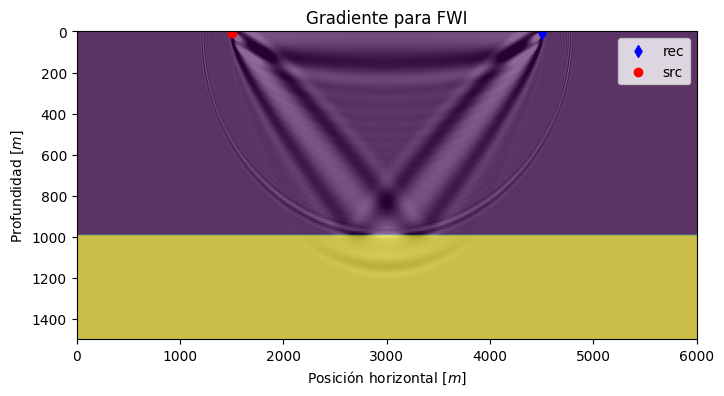

In [16]:
ni(x) = 10 * x ./ norm(x, Inf)

fig=figure(figsize=(8,4));
imshow(ni(g_fwi'), cmap="gray",  aspect="auto", vmin=-1, vmax=1, extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0], alpha=1)
imshow(v', cmap="viridis", extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0], aspect="auto", alpha=0.6)
scatter(xrec, zrec, label="rec", color="b", marker="d")
scatter(xsrc, zsrc, label="src", color="red")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Gradiente para FWI")
legend();

In [17]:
# ni(x) = 10 * x ./ norm(x, Inf)

# fig = figure(figsize=(8, 12))
# subplot(311)
# imshow(ni(g_isic'), cmap="gray", aspect="auto", vmin=-1, vmax=1, extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
# title("ISIC (inverse scattering)")
# subplot(312)
# imshow(ni(g_fwi'), cmap="gray",  aspect="auto", vmin=-1, vmax=1, extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
# title("FWI")
# subplot(313)
# imshow(ni(g_as'), cmap="gray",  aspect="auto", vmin=-1, vmax=1, extent=[0, (n[1]-1)*d[1], (n[2]-1)*d[2], 0])
# title("Adjoint State")
# tight_layout()
# # display(fig)